### Schwinger variational form (the ansatz) derived from VariationalForm class in Qiskit

In [11]:
from qiskit import *
import qiskit.tools.jupyter
import numpy as np
IBMQ.load_account()

/Users/Arthur/anaconda2/envs/Qiskitenv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [41]:
class SchwingerAnsatz(qiskit.aqua.components.variational_forms.VariationalForm):
    """ Variational Layer from Martin's Paper """
    
    CONFIGURATION = {
        'name': 'Schwinger Ansatz',
        'description': 'Variational Form for Schwinger VQE',
        'input_schema': {
            '$schema': 'http://json-schema.org/draft-07/schema#',
            'id': 'schwinger_schema',
            'type': 'object',
            'properties': {
                'depth': {
                    'type': 'integer',
                    'default': 3,
                    'minimum': 1
                },
                'entangler_map': {
                    'type': ['array', 'null'],
                    'default': None
                },
                'entanglement_gate': {
                    'type': 'string',
                    'default': 'cx',
                    'enum': ['cx']
                },
            },
            'additionalProperties': False
        },
        'depends': [
            {
                'pluggable_type': 'initial_state',
                'default': {
                    'name': 'ZERO',
                }
            },
        ],
    }
    
    def __init__(self, depth=3, entangler_map=None, initial_state=None):
        """
        Constructor.
        Args:
            depth (int) : number of rotation layers
            entangler_map (list[list]): describe the connectivity of qubits, each list describes
                             [source, target], or None for full entanglement.
                             Note that the order is the list is the order of
                             applying the two-qubit gate.
            initial_state (InitialState): an initial state object
        """
        self.validate(locals())
        super().__init__()
        # hard-coded, first pass through FIXME
        num_qubits = 2
        num_parameters = 3
        entanglement='full'
        entanglement_gate='cx'
        skip_unentangled_qubits = False
        self._num_qubits = num_qubits 
        self._depth = depth
        if entangler_map is None:
            self._entangler_map = qiskit.aqua.components.variational_forms.VariationalForm.get_entangler_map(entanglement, num_qubits)
        else:
            self._entangler_map = qiskit.aqua.components.variational_forms.VariationalForm.validate_entangler_map(entangler_map, num_qubits)
        # determine the entangled qubits
        all_qubits = []
        for src, targ in self._entangler_map:
            all_qubits.extend([src, targ])
        self._entangled_qubits = sorted(list(set(all_qubits)))
        self._initial_state = initial_state
        self._entanglement_gate = entanglement_gate
        self._skip_unentangled_qubits = skip_unentangled_qubits
        # for the first layer
        self._num_parameters = num_parameters
        # for repeated block
        self._num_parameters += num_parameters * (depth-1)
        self._bounds = [(-np.pi, np.pi)] * self._num_parameters
    
    def construct_circuit(self, parameters, q=None):
        """
        Construct the variational form, given its parameters.
        
        Args:
            parameters (numpy.ndarray): circuit parameters
            q (QuantumRegister): Quantum Register for the circuit.
            
        Returns:
            QuantumCircuit: a quantum circuit with given `parameters`
            
        Raises:
            ValueError: the number of parameters is incorrect.
        """
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))
        
        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        #
        param_idx = 0
        
        def angle(theta=0., phi=0., lam=0.):
            return [theta, phi, lam]

        for _ in range(self._depth):
            # get variational parameters for this layer
            t0 = parameters[param_idx] # theta-angle values
            t1 = parameters[param_idx+1]
            t2 = parameters[param_idx+2]
            t = [angle(t_i) for t_i in [t0, t1, t2]]
            # Construct circuit
            circuit.u3(*(t[1]), 0)  # u3(*angles, q)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[2]), 1)
            circuit.barrier(q)

        return circuit  

In [42]:
test = SchwingerAnsatz(1)

In [44]:
vqs_circ = test.construct_circuit([-0.386244, 0.317799, -0.416888])

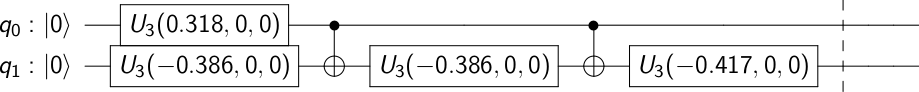

In [45]:
vqs_circ.draw(output='latex', scale=0.5)